In [60]:
using StaticArrays, SeeToDee

function asv(v, input, p, t)
    m1, m2, m3 = p[1], p[2], p[3]
    Xu, Yv, Yr, Nv, Nr = p[4], p[5], p[6], p[7], p[8]
    Xuu, Yvv, Nrr = p[9], p[10], p[11]
    Xuuu, Yvvv, Nrrr = p[12], p[13], p[14]
    
    u, v, r = v[1], v[2], v[3]
    X, Y, N = input[1], input[2], input[3]

    v1 = (1/m1) * (Xu*u + Xuu*abs(u)*u + Xuuu*u^3 + X)
    v2 = (1/m2) * (Yv*v + Yr*r + Yvv*abs(v)*v + Yvvv*v^3 + Y)
    v3 = (1/m3) * (Nv*v + Nr*r + Nrr*abs(r)*r + Nrrr*r^3 + N)

    return SA[v1, v2, v3]
end


measurement(v, u, p, t) = SA[v[1], v[2], v[3]]
Ts = 0.02
discrete_dynamics = SeeToDee.Rk4(asv, Ts, supersample=2)

SeeToDee.Rk4{typeof(asv), Float64}(asv, 0.02, 2)

In [61]:
using CSV
using DataFrames
using Plots

# Read the CSV data into a DataFrame
df = CSV.File("data.csv", header=false) |> DataFrame
t = df[:, 1]
# position and orientation
x = df[:, 2]
y = df[:, 3]
psi = df[:, 4]

# velocities (states)
u = df[:, 5]
v = df[:, 6]
r = df[:, 7]

# forces and moments (inputs)
Fx = df[:, 8]
Fy = df[:, 9]
Nz = df[:, 10]

nx = 3
ny = 3
nu = 3

3

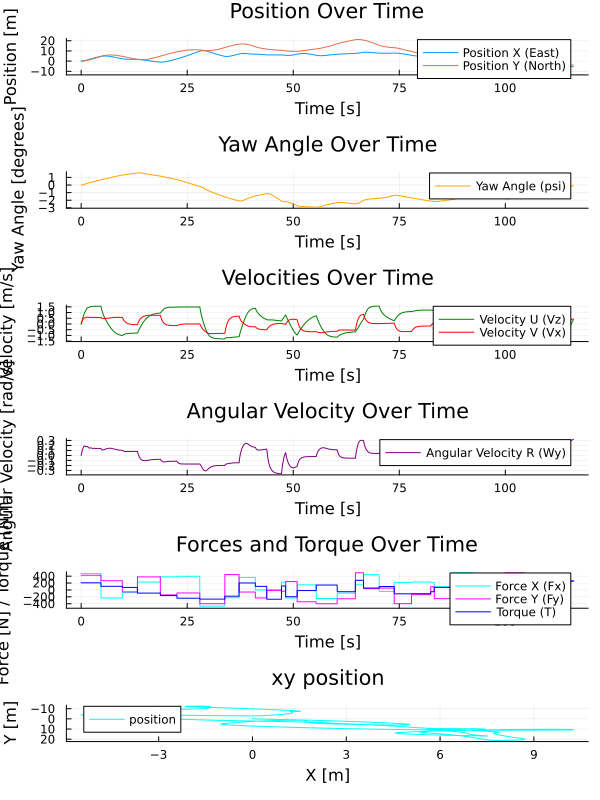

In [62]:
using Plots

plt = plot(layout = (6,1), size=(600,800))

plot!(plt[1], t, x, label="Position X (East)", legend=:topright)
plot!(plt[1], t, y, label="Position Y (North)", legend=:topright, xlabel="Time [s]", ylabel="Position [m]", title="Position Over Time")

plot!(plt[2], t, psi, label="Yaw Angle (psi)", color=:orange, legend=:topright, xlabel="Time [s]", ylabel="Yaw Angle [degrees]", title="Yaw Angle Over Time")

plot!(plt[3], t, u, label="Velocity U (Vz)", color=:green, legend=:topright, xlabel="Time [s]", ylabel="Velocity [m/s]", title="Velocities Over Time")
plot!(plt[3], t, v, label="Velocity V (Vx)", color=:red, legend=:topright)

plot!(plt[4], t, r, label="Angular Velocity R (Wy)", color=:purple, legend=:topright, xlabel="Time [s]", ylabel="Angular Velocity [rad/s]", title="Angular Velocity Over Time")

plot!(plt[5], t, Fx, label="Force X (Fx)", color=:cyan, legend=:topright, xlabel="Time [s]", ylabel="Force [N] / Torque [Nm]", title="Forces and Torque Over Time")
plot!(plt[5], t, Fy, label="Force Y (Fy)", color=:magenta, legend=:topright)
plot!(plt[5], t, Nz, label="Torque (T)", color=:blue, legend=:topright)

plot!(plt[6], x, y, label="position", color=:cyan, xlabel="X [m]", ylabel="Y [m]", title="xy position")
plot!(plt[6], yflip=true)

display(plt)

In [64]:
using ControlSystemIdentification, ControlSystemsBase
using ControlSystemsBase.DemoSystems: resonant
using LowLevelParticleFilters
using LeastSquaresOptim
using Random, Plots, LinearAlgebra

# Create input and output matrices
U = vcat.(Fx, Fy, Nz)
Y = vcat.(u, v, r) 

U = reduce(hcat, U)
Y = reduce(hcat, Y)

d = iddata(Y, U, Ts)
x0_guess = [0.1, 0.1, 0.1] # Guess for the initial condition
p_guess = zeros(14)

R1 = Diagonal([0.1, 0.1, 0.1])
R2 = Diagonal([0.1, 0.1, 0.1])

model = ControlSystemIdentification.nonlinear_pem(d, discrete_dynamics, measurement, p_guess, x0_guess, R1, R2, nu)

PosDefException: PosDefException: matrix is not Hermitian; Cholesky factorization failed.